In [1]:
import os, sys, math, datetime
import psutil
#import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from dotenv import load_dotenv

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths

import wandb
from wandb.keras import WandbCallback
#import deeplake


In [2]:
models_dir = initialize()

In [3]:
input_shape =(224,224,3)
#input_shape =(128,128,3)
classes = 3
alpha = 0.1

In [4]:
def get_model(input_shape, classes, alpha=1):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API. 
    The function returns the model.
    """

    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides = strides, padding= "same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters= filters, kernel_size = 1, strides=1)(x) # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters= 32* alpha, kernel_size = 3, strides=2, padding= "same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x) # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha , strides=2)

    for _ in range(5): # TODO: is this the depth factor in the keras implementation?
        x = mobilenet_v1_block(x, filters = 512, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    x = AvgPool2D(pool_size=7, strides=1 )(x) # TODO: data_format = "channels_first" needed?
    outputs = Dense(units= classes, activation="softmax")(x) # TODO: is there a stride=1 implementation in Dense?
    
    model = Model(inputs = inputs, outputs= outputs, name= "mobilenet_v1")
    #model.summary()
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=tf.keras.optimizers.Adam(0.0005),
    #     metrics =["accuracy"])
    
    return model

In [5]:
mobilenet_v1= get_model(input_shape, classes=classes, alpha=alpha)

In [6]:
mltk_summary = summarize_model(mobilenet_v1)
print(mltk_summary)

Model: "mobilenet_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 3)       84        
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 3)      12        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 3)       0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 3)      30        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 3)     

In [7]:
# mobilenet = tf.keras.applications.mobilenet.MobileNet(
#     input_shape=input_shape,
#     alpha=alpha,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=True,
#     weights=None, #'imagenet'
#     input_tensor=None,
#     pooling=None,
#     classes=classes,
#     classifier_activation='softmax',
#     #**kwargs
# )

In [8]:
#model = mobilenet
model = mobilenet_v1
model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [9]:
#summary = model.summary(expand_nested=True)

In [10]:
# generate folder structure for saving the models
channels = input_shape[-1]
print(channels)

3


In [11]:
# 
base_model_name = model.name
variation_code = "000" # code for special tweaks on the model
model_name = f"{base_model_name}_{alpha}_{input_shape[0]}_c{channels}_o{classes}_{variation_code}"
print(model_name)


mobilenet_v1_0.1_224_c3_o3_000


In [12]:

(models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path) = create_filepaths(model_name)

#mobilenet_v1 = keras.models.load_model(models_tf_path)

i:\tinyml\tiny_cnn\models


In [13]:
# models_path = models_dir.joinpath(model_name)
# if not models_path.exists():
#     print(f"{models_path} does not exist.")
#     models_path.mkdir()
#     print(f"Created path: {models_path}.")

# models_summary_path = models_dir.joinpath(model_name, f"{model_name}.txt")
# models_image_path = models_dir.joinpath(model_name, f"{model_name}.png")
# print(models_summary_path)
# models_tf_path = models_dir.joinpath(model_name, f"{model_name}.h5")
# models_tflite_path = models_dir.joinpath(model_name, f"{model_name}.tflite")
# models_tflite_opt_path = models_dir.joinpath(model_name, f"{model_name}_INT8.tflite")
# print(models_tflite_path)

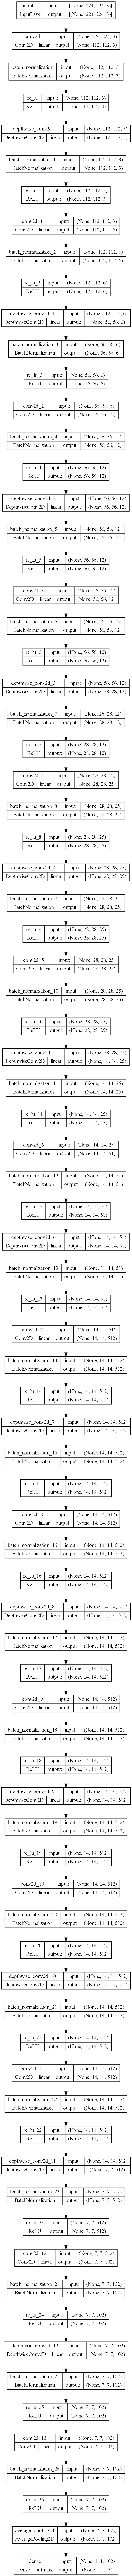

In [14]:
tf.keras.utils.plot_model(model, 
    to_file=models_image_path,
    show_shapes=True, 
    show_dtype=False,
    show_layer_names=True, 
    rankdir='TB', # TB for vertical plot, LR for horizontal plot
    expand_nested=True, 
    layer_range=None,
    dpi=200,
    show_layer_activations= True)

In [15]:
# from tensorflow.keras.models import Model
# def  Mymodel(backbone_model, classes):
#     backbone = backbone_model
#     x = backbone.output
#     x = tf.keras.layers.Dense(classes,activation='sigmoid')(x)
#     model = Model(inputs=backbone.input, outputs=x)
#     return model

# input_shape = (224, 224, 3)
# model = Mymodel(backbone_model=tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, pooling='avg'),
#                 classes=61)

# model.summary()

In [16]:
## Save the model summary

In [17]:
from contextlib import redirect_stdout

with open(models_summary_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [18]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.input.shape , layer.output_shape, layer.outbound_nodes, layer.compute_dtype, layer.count_params() )#layer.get_config())
#     if isinstance(layer, keras.layers.InputLayer):
#         print(f"Input Layer: {type(layer)}")

In [19]:
model.save(models_tf_path)
#model.save("test_Mobilenet.h5")

In [20]:
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenet_v1_0.1_224_c3_o3_000/mobilenet_v1_0.1_224_c3_o3_000.h5')

In [21]:
reconstructed_model = keras.models.load_model(models_tf_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

# Conversion to TFLite

In [22]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()

# Save the model.
with open(models_tflite_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmp4dis_id1\assets


# Conversion to TFLite with Quantization
A representative dataset is needed for quantization

In [23]:
data_dir = Path.cwd().parent.joinpath("lemon_dataset", "docs", "data")
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

shuffle_seed = 42

def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=1)
    )    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=batch_size)
    )

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #batch_size=batch_size)
    )
    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y))
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y))
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y))
    else:
        pass

    print (f"Class names: {class_names}")
    print(train_ds.element_spec)
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [24]:
# input_shape =(224,224,3)
IMG_WIDTH = input_shape[1]
IMG_HEIGHT = input_shape[0]
BATCH_SIZE =32

train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)

Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


In [25]:
#rep_ds =list(train_ds.as_numpy_iterator())
#rep_ds

In [26]:
# def representative_dataset(rep_ds):
#     for i in range(500):
#         yield(list(rep_ds[i].reshape(1,1)))
# representative_dataset(rep_ds)

In [27]:
# Convert the model to the TensorFlow Lite format with quantization
# def representative_dataset():
#   for i in range(500):
#     yield([x_train[i].reshape(1, 1)])



In [28]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
rep_ds = train_ds.unbatch()

In [30]:
def representative_data_gen():
    #for input_value in train_ds.unbatch.batch(1).take(100):
    for input_value, output_value in rep_ds.batch(1).take(100):
    # Model has only one input so each data point has one element.
      print(input_value)
      yield [input_value]

In [31]:
test_ds = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                      interpolation="bilinear",
                                                      image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      #batch_size=1)
)

rescale = tf.keras.layers.Rescaling(1./255, offset= -1)                                                      
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 2528 files belonging to 3 classes.


In [32]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
repr_ds = test_ds.unbatch()
repr_ds

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [34]:

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
  #for i_value, o_value in test_ds.take(48):
  #for i_value, o_value in train_ds.take(48):
  #for i_value, o_value in repr_ds.take(48):
    yield [i_value]

# next(representative_data_gen())

In [35]:
#converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)
#converter_INT = tf.lite.TFLiteConverter.from_saved_model(str(models_path))
converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)
    
# Set the optimization flag.
converter_INT.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter_INT.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_INT.inference_input_type = tf.int8
converter_INT.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
#converter_INT.representative_dataset = representative_dataset(rep_ds)
converter_INT.representative_dataset = representative_data_gen
#converter_INT.representative_dataset = rep_ds
model_tflite_opt = converter_INT.convert()

# Save the model to disk
with open(models_tflite_opt_path, 'wb') as f:
  f.write(model_tflite_opt)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmp_ncr93nt\assets


d:\Miniconda\envs\tiny_cnn\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [36]:
# # repr_ds = test_ds.unbatch()

# # def representative_data_gen():
# #   for i_value, o_value in repr_ds.batch(1).take(48):
# #     yield [i_value]
# converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
# #converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# # converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# #converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# #converter_opt.inference_input_type = tf.int8

# tflite_model_opt = converter_opt.convert()

# # Save the model.
# with open(models_tflite_opt_path, 'wb') as f:
#   f.write(tflite_model_opt)

In [37]:
models_tflite_opt_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenet_v1_0.1_224_c3_o3_000/mobilenet_v1_0.1_224_c3_o3_000_INT8.tflite')

In [38]:
str(models_tflite_opt_path)

'i:\\tinyml\\tiny_cnn\\models\\mobilenet_v1_0.1_224_c3_o3_000\\mobilenet_v1_0.1_224_c3_o3_000_INT8.tflite'

## Get the TFLite model size in bytes

In [39]:
size_tfl_model = len(model_tflite_opt)
print(len(model_tflite_opt), "bytes")

1331544 bytes


### Convert the TFLite model to C-byte array with xxd

In [40]:
# #open("model.tflite", "wb").write(tfl_model)
# !apt-get update && apt-get -qq install xxd
# #!xxd -c 60 -i model.tflite > indoor_scene_recognition.h
# !xxd -c 60 -i i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96_c3\\mobilenet_0.25_96_c3_INT8.tflite' > model_INT.h